In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
from pathlib import Path

In [2]:
ort.get_available_providers()

['AzureExecutionProvider', 'CPUExecutionProvider']

In [3]:
print(Path.cwd().resolve())

/home/ngocchau/Documents/projects/_yolo/object_detection/src


In [4]:
model_path = Path.cwd().resolve().parent / "model"
test_data_path = Path.cwd().resolve().parent / "test_data"
v5_model_path = model_path / "v5_runs"
v10_model_path = model_path / "v10_runs"

# Run inference with ONNXRuntime

In [5]:
v5_session = ort.InferenceSession(v5_model_path / "weights" / "best.onnx")
v10_session = ort.InferenceSession(v10_model_path / "weights" / "best.onnx")

In [6]:
v5_session.get_inputs()[0].shape

[1, 3, 640, 640]

In [7]:
v10_session.get_inputs()[0].shape

[1, 3, 640, 640]

## Reshape input image

In [8]:
img = cv.imread(test_data_path / "street_image.jpg")
img_resized = cv.resize(img, (640, 640))
input_img = np.expand_dims(np.moveaxis(img_resized, 2, 0), 0).astype(np.float32) / 255
input_img.shape

(1, 3, 640, 640)

In [9]:
input_img.min(), input_img.max(), input_img.mean()

(np.float32(0.0), np.float32(1.0), np.float32(0.30838102))

In [10]:
v5_input_name = v5_session.get_inputs()[0].name
v5_output_name = v5_session.get_outputs()[0].name

v10_input_name = v10_session.get_inputs()[0].name
v10_output_name = v10_session.get_outputs()[0].name

## Inference
Perform inference on both YOLOv5 and YOLOv10 models

In [11]:
v5_preds = v5_session.run([v5_output_name], {v5_input_name: input_img})
v10_preds = v10_session.run([v10_output_name], {v10_input_name: input_img})

In [12]:
type(v5_preds), type(v10_preds)

(list, list)

In [13]:
v5_preds[0].shape, v10_preds[0].shape

((1, 300, 6), (1, 300, 6))

In [14]:
v5_preds_sub = v5_preds[0][0]
v10_preds_sub = v10_preds[0][0]

In [15]:
v5_preds_sub.shape

(300, 6)

In [16]:
np.unique(v10_preds_sub[:, 5])

array([ 3.,  5.,  6.,  9., 11., 14., 17., 18.], dtype=float32)

In [17]:
def extract_bb_conf_clsidx(preds: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    bboxes = preds[:, :4].astype(int)
    conf = preds[:, 4].astype(np.float32)
    class_idx = preds[:, 5].astype(int)
    return bboxes, conf, class_idx

In [18]:
v10_bboxes, v10_conf_scores, v10_cls_idx = extract_bb_conf_clsidx(v10_preds_sub)
v5_bboxes, v5_conf_scores, v5_cls_idx = extract_bb_conf_clsidx(v5_preds_sub)

In [19]:
v10_bboxes.shape

(300, 4)

In [20]:
v10_indices = cv.dnn.NMSBoxesBatched(v10_bboxes, v10_conf_scores, v10_cls_idx, score_threshold=0.2, nms_threshold=0.5)
v5_indices = cv.dnn.NMSBoxesBatched(v5_bboxes, v5_conf_scores, v5_cls_idx, score_threshold=0.2, nms_threshold=0.5)

print(v10_indices)
print(v5_indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11 14]
[ 0  1  2  3  4  5  6  9 10 11]


In [21]:
v10_cls_idx[v10_indices]

array([ 5,  6, 14, 14,  6,  5,  5,  5, 14,  6, 14,  6,  6])

In [22]:
v5_img = img_resized.copy()
v10_img = img_resized.copy()

for bbox in v5_bboxes[v5_indices]:
    x1, y1, x2, y2 = bbox
    cv.rectangle(v5_img, (x1, y1), (x2, y2), (255, 0, 0), 2)

for bbox in v10_bboxes[v10_indices]:
    x1, y1, x2, y2 = bbox
    cv.rectangle(v10_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

In [23]:
v5_img = cv.cvtColor(v5_img, cv.COLOR_BGR2RGB)
v10_img = cv.cvtColor(v10_img, cv.COLOR_BGR2RGB)

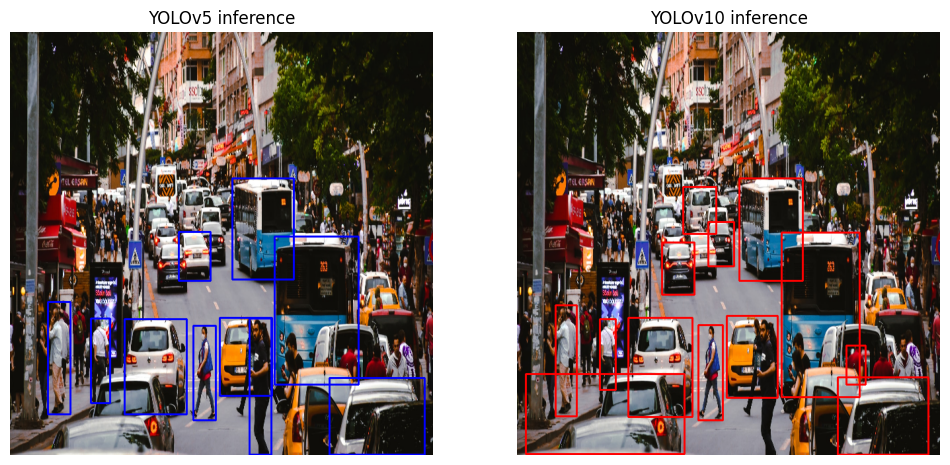

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(v5_img)
axes[0].set_title("YOLOv5 inference")
axes[1].imshow(v10_img)
axes[1].set_title("YOLOv10 inference")

for ax in axes:
    ax.set_axis_off()
    ax.set_aspect("equal")

plt.show()

# Reconstruct the image to the original size from 640 x 640 image

In [25]:
h, w, d = img.shape

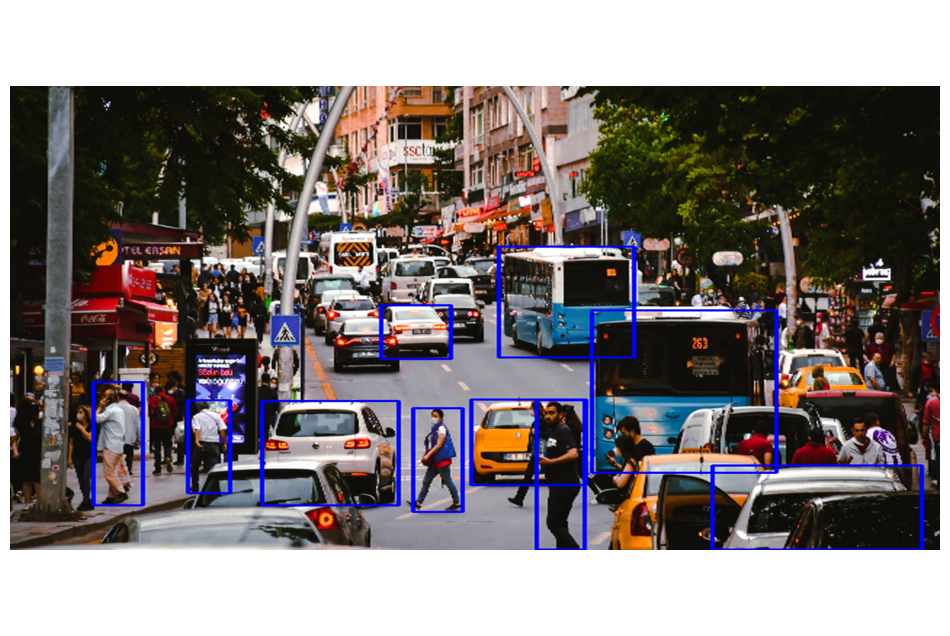

In [26]:
fx = w / 640
fy = h / 640
reconstructed_img = cv.resize(v5_img, None, fx=fx, fy=fy, interpolation=cv.INTER_CUBIC)

plt.figure(figsize=(12, 8))
plt.imshow(reconstructed_img)
plt.axis("off")
plt.axis("equal")
plt.show()

# Something

In [27]:
preds = v5_preds[0][0]
conf = preds[:, 4]
class_id = preds[:, 5]
bbox = preds[:, :4]

indices = cv.dnn.NMSBoxes(bbox, conf, 0.25, 0.7)

In [28]:
print(indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [29]:
def random_assign_class_to_color(class_id: int, seed: int = 42) -> tuple[int, int, int]:
    rng = np.random.default_rng(seed)
    r = int(np.exp(class_id + rng.integers(class_id, class_id + 255)) % 255)
    g = int(np.exp(class_id + rng.integers(class_id, class_id + 255)) % 255)
    b = int(np.exp(class_id + rng.integers(class_id, class_id + 255)) % 255)
    return r, g, b

In [30]:
def visualize_rgb(r: int, g: int, b: int, img_size: tuple[int, int]):
    img = np.zeros((*img_size, 3), dtype=np.uint8)
    img[:, :, 0] = r
    img[:, :, 1] = g
    img[:, :, 2] = b
    plt.imshow(img)
    plt.axis("off")
    plt.axis("equal")
    plt.show()

In [31]:
import yaml

with open("../datasets.yaml", "r") as f:
    yml = yaml.safe_load(f)

classes = [v for v in yml["names"].values()]
print(classes)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [32]:
v5_img.shape

(640, 640, 3)

resized_coor * factor = orig_coor

In [39]:
def reconstruct_img(orig_img, img_resized):
    h, w, _ = orig_img.shape
    fx = w / 640
    fy = h / 640
    return cv.resize(img_resized, None, fx=fx, fy=fy)


def draw_bounding_boxes(img: np.ndarray, preds: np.ndarray, indices: np.ndarray):
    new_img = img.copy()
    h, w, _ = new_img.shape
    fx = w / 640
    fy = h / 640

    for idx in indices:
        row = preds[idx]
        x1, y1, x2, y2 = row[:4].astype(int)
        x1, x2 = int(x1 * fx), int(x2 * fx)
        y1, y2 = int(y1 * fy), int(y2 * fy)
        class_id = row[5].astype(int)
        cv.rectangle(new_img, (x1, y1), (x2, y2), random_assign_class_to_color(class_id), 2)
    return new_img


def annotate_bounding_boxes(
    img: np.ndarray,
    preds: np.ndarray,
    indices: np.ndarray,
    classes: list,
    font_face=cv.FONT_HERSHEY_PLAIN,
    font_scale=1,
    thickness=1,
):
    new_img = img.copy()
    h, w, _ = new_img.shape
    fx = w / 640
    fy = h / 640
    for idx in indices:
        row = preds[idx]
        x1, y1, x2, y2 = row[:4].astype(int)
        x1, x2 = int(x1 * fx), int(x2 * fx)
        y1, y2 = int(y1 * fy), int(y2 * fy)
        conf = row[4] * 100
        class_id = row[5].astype(int)
        class_label = classes[class_id]

        text = f"{class_label}: {conf:.2f}%"
        (text_w, text_h), _ = cv.getTextSize(text, font_face, font_scale, thickness)
        pad = text_h // 4
        cv.rectangle(new_img, (x1, y1), (x1 + text_w, y1 - text_h - pad), (250, 250, 250), cv.FILLED)
        cv.putText(new_img, text, (x1, y1 - pad), font_face, font_scale, (1, 1, 1), thickness=thickness)

    return new_img


img = cv.imread(test_data_path / "street_image.jpg")
bb_img = draw_bounding_boxes(img, preds, indices)
annotated = annotate_bounding_boxes(bb_img, preds, indices, classes)

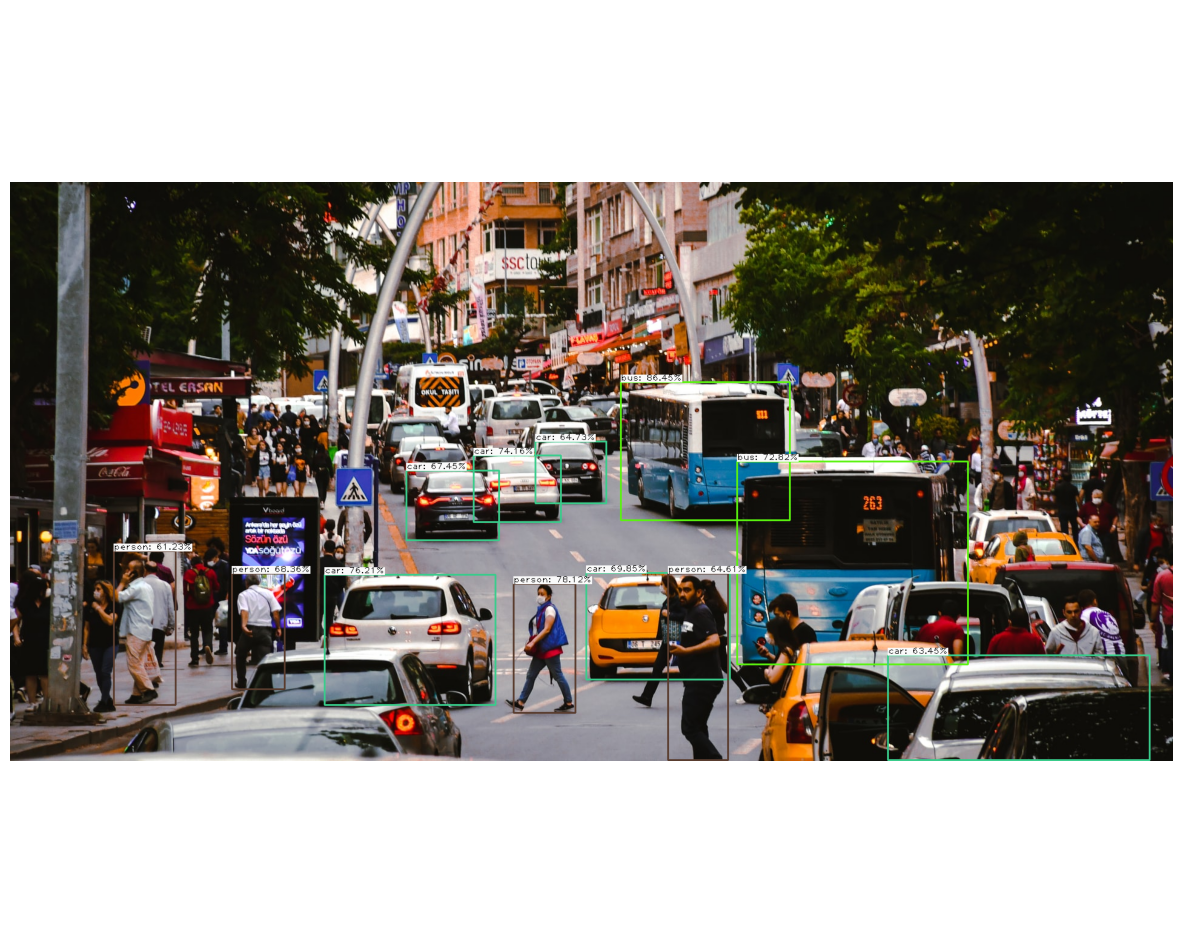

In [40]:
rgb = cv.cvtColor(annotated, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15, 12))
plt.axis("off")
plt.axis("equal")
plt.imshow(rgb)
plt.show()